# Batch effect removal for the entire rnaseq dataset
### Jam session started on 04-24-2018

Generate multiple datasets:
- source scaling and combat for `combined_rnaseq_data` and `combined_rnaseq_data_lincs1000`
- source scaling and combat for `combined_rnaseq_data` and `combined_rnaseq_data_lincs1000` from Apr2018

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

In [3]:
utils_path = os.path.abspath(os.path.join('..', 'utils_py'))
sys.path.append(utils_path)

In [4]:
from pilot1_imports import *

In [5]:
os.getcwd()

'/Users/apartin/Dropbox/work/combo/normalize_rnaseq'

### Utils

In [6]:
def check_mapping_cells(df, cl_mapping):
    d1 = cl_mapping.merge(df, left_on='from_cell', right_on='Sample')
    d1 = d1.sort_values('from_cell')
    d1 = d1.drop(columns=['from_cell', 'to_cell'])
    
    d2 = cl_mapping.merge(df, left_on='to_cell', right_on='Sample')
    d2 = d2.sort_values('from_cell')
    d2 = d2.drop(columns=['from_cell', 'to_cell'])
    
    diff = (d1.iloc[:, 1:].values - d2.iloc[:, 1:].values).sum()
    return diff

## Load data

In [7]:
DATAPATH = '/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1'
# DATAPATH = '/Users/apartin/work/jdacs/jam_04242018'
# DATAPATH = '/Users/apartin/work/jdacs/jam_04242018/Apr2018'

OUTDIR = '.'

# RNA-Seq dataset
# DATASET = 'combined_rnaseq_data'
DATASET = 'combined_rnaseq_data_lincs1000'
# DATASET = 'combined_rnaseq_data_oncogenes'

# Metadata
# PDM_METADATA_FILENAME = 'comb_sample_metadata_march2018.txt'
PDM_METADATA_FILENAME = 'combined_metadata_2018May.txt'

In [8]:
# Load rnaseq
df_rna = load_combined_rnaseq(dataset=os.path.join(DATAPATH, DATASET), chunksize=2000, verbose=True)

Loading dataframe by chunks...
/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1/combined_rnaseq_data_oncogenes: (15196, 1942)
gdc       11081
ncipdm     1198
ccle       1018
ctrp        812
gdsc        670
gcsi        357
nci60        60
Name: Sample, dtype: int64


In [9]:
df_rna_org = df_rna.copy()

In [10]:
# Choose datasets to process

# datasets_to_keep = ['ccle', 'ctrp', 'gdsc', 'ncipdm', 'gcsi', 'nci60']
datasets_to_keep = ['ccle', 'gdc', 'nci60', 'ncipdm']
# datasets_to_keep = None
# use_metadata_file = False
use_metadata_file = True

# datasets_to_keep = ['ncipdm', 'nci60']
# use_metadata_file = True

In [11]:
# Get the metadata
if use_metadata_file:
    # Load metadata file
    meta = pd.read_csv(os.path.join(DATAPATH, PDM_METADATA_FILENAME), sep='\t')
    # meta = update_metadata_comb(meta)
    meta = update_metadata_comb_may2018(meta)
    meta = extract_specific_datasets(meta, datasets_to_keep = datasets_to_keep)
    df_rna, meta = update_df_and_meta(df_rna=df_rna, meta=meta, on='Sample')
else:
    # If not using metadata file then use the source as meta
    meta = extract_specific_datasets(df_rna, datasets_to_keep = datasets_to_keep)
    meta['source'] = meta['Sample'].map(lambda x: x.split('.')[0].lower())  # add `source` col
    meta = meta[['Sample', 'source']]  # keep only `Sample` and `source` cols
    df_rna, meta = update_df_and_meta(df_rna=df_rna, meta=meta, on='Sample')

In [12]:
print(df_rna.shape)
df_rna[:2]

(13357, 1942)


,Sample,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABI1,ABL1,...,ZNF451,ZNF521,ZNF586,ZNF589,ZNF638,ZNF703,ZNF750,ZNF814,ZRSR2,ZW10
0,CCLE.22RV1,8.31,7.17,4.12,5.64,6.04,3.94,2.08,5.86,5.24,...,3.90,0.03,4.19,3.88,5.38,1.08,0.23,2.57,3.42,5.37
1,CCLE.2313287,8.94,6.30,3.83,6.60,5.99,6.34,3.72,6.30,4.67,...,3.97,0.04,3.82,3.78,5.39,4.56,0.25,2.18,3.77,5.49


In [13]:
# Load the cell line mapping
cl_mapping = pd.read_csv(os.path.join(DATAPATH, 'cl_mapping'), sep='\t', header=None)
cl_mapping.rename(columns={0: 'from_cell', 1: 'to_cell'}, inplace=True)
print(cl_mapping.shape)
cl_mapping[:2]

(1841, 2)


,from_cell,to_cell
0,CCLE.22RV1,GDSC.22RV1
1,CCLE.2313287,GDSC.23132-87


### Raw data

Explained variance by PCA components [1, 2]:  [0.37506, 0.11309]


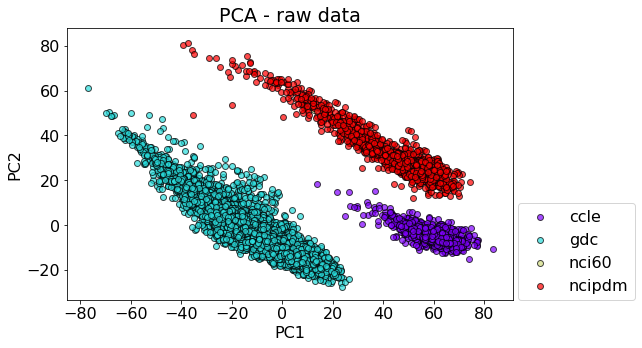

In [14]:
plot_pca(df_rna.iloc[:, 1:],
         color_vector = df_rna['Sample'].map(lambda x: x.split('.')[0].lower()),
         components = [1, 2], to_scale=True, title='PCA - raw data');

### Per-source scaling

In [15]:
df_rna_sc = scale_rnaseq(df=df_rna, per_source=True)

Scaling ccle
Scaling gdc
Scaling nci60
Scaling ncipdm


Explained variance by PCA components [1, 2]:  [0.28916, 0.06277]


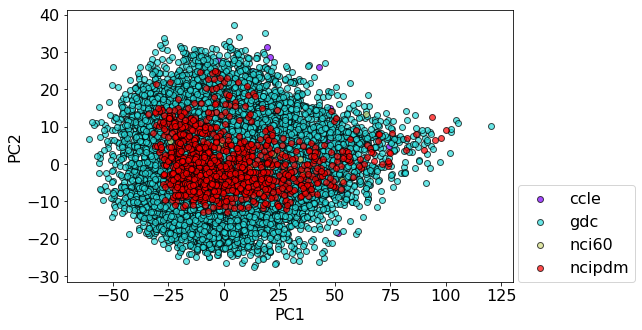

In [16]:
plot_pca(df_rna_sc.iloc[:, 1:],
         color_vector = df_rna_sc['Sample'].map(lambda x: x.split('.')[0].lower()),
         components = [1, 2], to_scale=True, title=None);

In [17]:
df_rna_sc = copy_rna_profiles_to_cell_lines(df_rna_sc, cl_mapping)

In [18]:
check_mapping_cells(df_rna_sc, cl_mapping)

0.0

In [19]:
df_rna_sc = df_rna_sc.sort_values('Sample')

In [20]:
filename = DATASET + '_source_scale'
df_rna_sc.to_csv(os.path.join(OUTDIR, filename), sep='\t', float_format=np.float16, index=False)

#### Note that there are 2 extra gdsc cell lines added from cl_mapping (??)

In [21]:
df_rna_sc.Sample.map(lambda x: x.split('.')[0].lower()).value_counts()

gdc       11081
ncipdm     1198
ccle       1018
ctrp        812
gdsc        672
gcsi        357
nci60        60
Name: Sample, dtype: int64

In [22]:
df_rna_org.Sample.map(lambda x: x.split('.')[0].lower()).value_counts()

gdc       11081
ncipdm     1198
ccle       1018
ctrp        812
gdsc        670
gcsi        357
nci60        60
Name: Sample, dtype: int64

In [23]:
set(df_rna_sc['Sample'].tolist()) - set(df_rna_org['Sample'].tolist())

{'GDSC.KMH-2', 'GDSC.T-T'}

### Combat

In [24]:
df_rna_be = ap_combat(df_rna, meta)

found 4 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


Explained variance by PCA components [1, 2]:  [0.28926, 0.06281]


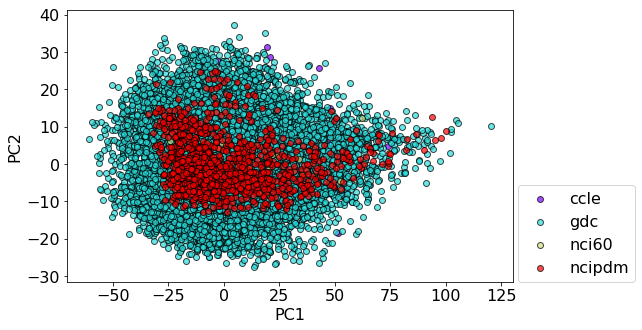

In [25]:
plot_pca(df_rna_be.iloc[:, 1:],
         color_vector = df_rna_be['Sample'].map(lambda x: x.split('.')[0].lower()),
         components = [1, 2], to_scale=True, title=None);

In [26]:
df_rna_be = copy_rna_profiles_to_cell_lines(df_rna_be, cl_mapping)

In [27]:
check_mapping_cells(df_rna_be, cl_mapping)

0.0

In [28]:
df_rna_be = df_rna_be.sort_values('Sample')

In [29]:
filename = DATASET + '_combat'
df_rna_be.to_csv(os.path.join(OUTDIR, filename), sep='\t', float_format=np.float16, index=False)

# Load and check the stored data

In [30]:
# DATAPATH = '/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1'
# DATAPATH = '/Users/apartin/work/jdacs/jam_04242018'
# DATAPATH = '/Users/apartin/work/jdacs/jam_04242018/Apr2018'

# RNA-Seq dataset
# DATASET = 'combined_rnaseq_data_combat'
# DATASET = 'combined_rnaseq_data__scale_per_source'

DATASET = 'combined_rnaseq_data_lincs1000_combat'
# DATASET = 'combined_rnaseq_data_lincs1000_scale_per_source'

In [31]:
df_rna = load_combined_rnaseq(dataset=os.path.join(DATAPATH, DATASET), chunksize=2000, verbose=True)

Loading dataframe by chunks...
/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1/combined_rnaseq_data_lincs1000_combat: (15198, 943)
gdc       11081
ncipdm     1198
ccle       1018
ctrp        812
gdsc        672
gcsi        357
nci60        60
Name: Sample, dtype: int64


Explained variance by PCA components [1, 2]:  [0.27019, 0.06032]


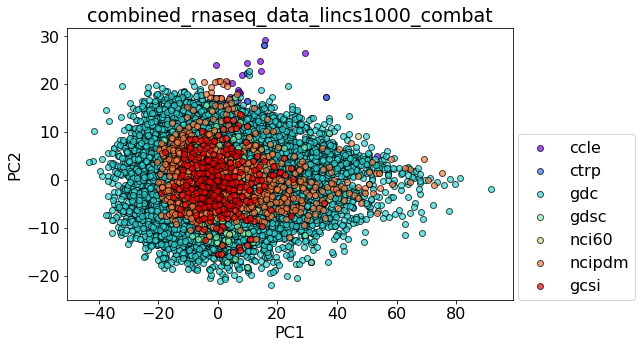

In [32]:
plot_pca(df_rna.iloc[:, 1:],
         color_vector = df_rna['Sample'].map(lambda x: x.split('.')[0].lower()),
         components = [1, 2], to_scale=True, title=DATASET);